In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_absolute_error
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
from pathlib import Path
import os
from datetime import datetime
import pickle

## Parameters

In [2]:
data_file = os.path.join(os.getcwd(), "CAISO_Data_2019_2021_NN.csv")
model_save_dir = os.path.join(os.getcwd(), "FF_models")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_out = 3    # 3 output parameters: MEF, MDF, interecept. 
             # inclusion of intercept is debatable (we'd love to have a model where it is zero),
             # and so far it has not much impacted r^2.
             # once we do test train split i only want to keep it if it notably improves model accuracy

In [3]:
device

device(type='cuda')

## data exploration

In [4]:
data_df = pd.read_csv(data_file)

In [5]:
data_df.head()

,Unnamed: 0,Load,Net Load,Total_CO2_Emissions,Total_SO2_Emissions,Total_NOX_Emissions,VRE,delta_Load,delta_Net_Load,delta_Total_CO2_Emissions,delta_Total_SO2_Emissions,delta_Total_NOX_Emissions,delta_VRE
0,2019-01-01 00:00:00,22822.964472,20502.358502,5.103942e+06,425.327933,1632.821698,2320.593616,-1285.054865,-1255.110267,-337029.794143,-24.142180,-98.530417,-29.956338
1,2019-01-01 01:00:00,21879.620618,19606.836908,4.867578e+06,404.315852,1557.650531,2272.780097,-944.689268,-896.922625,-243021.833700,-21.594332,-76.882199,-47.757034
2,2019-01-01 02:00:00,21257.454020,19056.267637,4.723101e+06,383.695714,1496.197481,2201.182455,-614.641020,-545.206677,-144846.797503,-20.952957,-61.425638,-69.432802
3,2019-01-01 03:00:00,20974.800758,18871.418601,4.693112e+06,380.561848,1466.329836,2103.388502,-281.391674,-191.565227,-24776.569759,-2.164379,-28.118595,-89.815150
4,2019-01-01 04:00:00,20327.083333,18012.666667,5.032423e+06,711.911968,2391.657870,2314.666667,30.416667,74.416667,49254.136541,69.703951,71.970840,-43.916667


## Data Loading and pre-processing

In [6]:
CAISO_Data = pd.read_csv(data_file, index_col=0)
CAISO_Data.index = pd.to_datetime(CAISO_Data.index)

In [13]:
CAISO_Data.index[0]

Timestamp('2019-01-01 00:00:00')

In [11]:
# number of hours since earliest data point
(CAISO_Data.index[1] - CAISO_Data.index[0]).total_seconds() // 3600

1.0

In [14]:
# read in the processed data. there should be zero nans or missing data.
CAISO_Data = pd.read_csv(data_file, index_col=0)
CAISO_Data.index = pd.to_datetime(CAISO_Data.index)

### Feature engineering...

## Temporal features
CAISO_Data.loc[:,"Day_of_Year"] = [instant.timetuple().tm_yday for instant in CAISO_Data.index]
CAISO_Data.loc[:,"Hour"] = CAISO_Data.index.hour
# number of hours since earliest data point
def hours_since_2018(instant):
    return (instant - CAISO_Data.index[0]).total_seconds() // 3600
CAISO_Data.loc[:,"Hours_since_2018"] = [hours_since_2018(instant) for instant in CAISO_Data.index]
# CAISO_Data.loc[:,"Is_Weekend"] = [instant.weekday() > 4 for instant in CAISO_Data.index]
# for day_of_week in range(7):
#     CAISO_Data.loc[:,f"Day_of_Week={day_of_week}"] = [instant.weekday() ==day_of_week for instant in CAISO_Data.index]

## Recent history features
# prev_time_steps = [1,2]#,24,3]
# for i in prev_time_steps:
#     CAISO_Data.loc[:,f"Load_t-{i}"] = ([np.nan] * i) + list(CAISO_Data.iloc[:-i].loc[:,"Load"])
#     CAISO_Data.loc[:,f"VRE_t-{i}"] = ([np.nan] * i) + list(CAISO_Data.iloc[:-i].loc[:,"VRE"])
#     # CAISO_Data.loc[:,f"d_emissions_t-{i}"] = ([np.nan] * i) + list(CAISO_Data.iloc[:-i].loc[:,"delta_Total_CO2_Emissions"])
#     CAISO_Data.loc[:,f"Net_load_t-{i}"] = ([np.nan] * i) + list(CAISO_Data.iloc[:-i].loc[:,"Net Load"])
# # Drop rows that don't have all prev-time-step features
# CAISO_Data = CAISO_Data.iloc[max(prev_time_steps):]


## load and VRE derivatives
# CAISO_Data.loc[:,"Load_d1"] = [np.nan] + list(CAISO_Data.iloc[1:].loc[:,"Load"].values - CAISO_Data.iloc[:-1].loc[:,"Load"].values)
# CAISO_Data.loc[:,"Load_d2"] = [np.nan, np.nan] + list(CAISO_Data.iloc[2:].loc[:,"Load_d1"].values - CAISO_Data.iloc[1:-1].loc[:,"Load_d1"].values)
# CAISO_Data.loc[:,"VRE_d1"] = [np.nan] + list(CAISO_Data.iloc[1:].loc[:,"VRE"].values - CAISO_Data.iloc[:-1].loc[:,"VRE"].values)
# CAISO_Data.loc[:,"VRE_d2"] = [np.nan, np.nan] + list(CAISO_Data.iloc[2:].loc[:,"VRE_d1"].values - CAISO_Data.iloc[1:-1].loc[:,"VRE_d1"].values)
#CAISO_Data.loc[:,"Net_Load_d1"] = [np.nan] + list(CAISO_Data.iloc[1:].loc[:,"Net Load"].values - CAISO_Data.iloc[:-1].loc[:,"Net Load"].values)
# CAISO_Data.loc[:,"Net_Load_d2"] = [np.nan, np.nan] + list(CAISO_Data.iloc[2:].loc[:,"Net_Load_d1"].values - CAISO_Data.iloc[1:-1].loc[:,"Net_Load_d1"].values)
# # Drop rows that don't have all features
#CAISO_Data = CAISO_Data.iloc[1:]


num_samples = len(CAISO_Data)

# create masks for train, validation and test data
percent_train, percent_val, percent_test = .6, .2, .2
num_train, num_val = int(percent_train * num_samples), int(percent_val * num_samples)
num_test = num_samples - num_train - num_val
set_assignments = np.array([1 for i in range(num_train)] + [2 for i in range(num_val)] + [3 for i in range(num_test)])
np.random.seed(1)
np.random.shuffle(set_assignments)
train_mask = set_assignments == 1
val_mask = set_assignments == 2
test_mask = set_assignments == 3
CAISO_train = CAISO_Data.loc[train_mask]
CAISO_val = CAISO_Data.loc[val_mask]
CAISO_test = CAISO_Data.loc[test_mask]

## old features we've tried
# feature_cols = ['Load', 'VRE', 'Hour', 'Month', 'Day', 'Pas_Temp', 'SJ_Temp', 'NH_Temp', 'SB_Temp', 'Sac_Temp', 'Fres_Temp', 'LB_Temp']
# feature_cols = ['Load', 'VRE', 'Hour', 'Day_of_Year', 'Is_Weekend', 'Pas_Temp', 'SJ_Temp', 'NH_Temp', 'SB_Temp', 'Sac_Temp', 'Fres_Temp', 'LB_Temp']
# feature_cols = ['Load', 'VRE', 'Hour', 'Day_of_Year', 'Pas_Temp', 'SJ_Temp', 'NH_Temp', 'SB_Temp', 'Sac_Temp', 'Fres_Temp', 'LB_Temp']
# feature_cols.extend([f"Day_of_Week={day_of_week}" for day_of_week in range(7)])

feature_cols = ['Load', 'VRE', 'Hour', 'Day_of_Year', "Hours_since_2018"]
# feature_cols.extend([f"Load_t-{i}" for i in prev_time_steps] + [f"VRE_t-{i}" for i in prev_time_steps])
# feature_cols.extend(["Load_d1", "Load_d2", "VRE_d1", "VRE_d2"])
# feature_cols.extend(["delta_Load", "delta_VRE"])
# feature_cols.extend([f"d_emissions_t-{i}" for i in prev_time_steps])
# feature_cols.extend([f"Net_load_t-{i}" for i in prev_time_steps])
# feature_cols.extend(["Net_Load_d1"])

# specify x and y data #TODO seems like there may be some unnecessary operations here... 
train_x = torch.tensor(CAISO_train[feature_cols].values.astype(np.float32))
val_x = torch.tensor(CAISO_val[feature_cols].values.astype(np.float32))
test_x = torch.tensor(CAISO_test[feature_cols].values.astype(np.float32))
# train_y = torch.tensor(np.array(CAISO_train['delta_Total_CO2_Emissions'].values).astype(np.float32))
# val_y = torch.tensor(np.array(CAISO_val['delta_Total_CO2_Emissions'].values).astype(np.float32))
# test_y = torch.tensor(np.array(CAISO_test['delta_Total_CO2_Emissions'].values).astype(np.float32))


# standardize data based on mean and variance of train data
scaler = preprocessing.StandardScaler()
scaler.fit(train_x)
train_x = torch.tensor(scaler.transform(train_x)).to(device)
val_x = torch.tensor(scaler.transform(val_x)).to(device)
test_x = torch.tensor(scaler.transform(test_x)).to(device)

# save scaler for later re-use
with open(os.path.join(model_save_dir, "scaler.hours_since_2018.pkl"), 'wb') as f:
    pickle.dump(scaler, f)

In [16]:
CAISO_Data.iloc[:5]

,Load,Net Load,Total_CO2_Emissions,Total_SO2_Emissions,Total_NOX_Emissions,VRE,delta_Load,delta_Net_Load,delta_Total_CO2_Emissions,delta_Total_SO2_Emissions,delta_Total_NOX_Emissions,delta_VRE,Day_of_Year,Hour,Hours_since_2018
2019-01-01 00:00:00,22822.964472,20502.358502,5.103942e+06,425.327933,1632.821698,2320.593616,-1285.054865,-1255.110267,-337029.794143,-24.142180,-98.530417,-29.956338,1,0,0.0
2019-01-01 01:00:00,21879.620618,19606.836908,4.867578e+06,404.315852,1557.650531,2272.780097,-944.689268,-896.922625,-243021.833700,-21.594332,-76.882199,-47.757034,1,1,1.0
2019-01-01 02:00:00,21257.454020,19056.267637,4.723101e+06,383.695714,1496.197481,2201.182455,-614.641020,-545.206677,-144846.797503,-20.952957,-61.425638,-69.432802,1,2,2.0
2019-01-01 03:00:00,20974.800758,18871.418601,4.693112e+06,380.561848,1466.329836,2103.388502,-281.391674,-191.565227,-24776.569759,-2.164379,-28.118595,-89.815150,1,3,3.0
2019-01-01 04:00:00,20327.083333,18012.666667,5.032423e+06,711.911968,2391.657870,2314.666667,30.416667,74.416667,49254.136541,69.703951,71.970840,-43.916667,1,4,4.0


In [17]:
train_x.shape

torch.Size([15783, 5])

In [18]:
feature_cols

['Load', 'VRE', 'Hour', 'Day_of_Year', 'Hours_since_2018']

In [19]:
train_x[:,-1]

tensor([-1.7185, -1.7183, -1.7182,  ...,  1.7355,  1.7357,  1.7358],
       device='cuda:0', dtype=torch.float64)

## define model loss function

In [20]:
def get_model(n_input, hidden_dims, n_out, dropout_p):
    
    layers = [nn.Linear(n_input, hidden_dims[0]),
              nn.BatchNorm1d(hidden_dims[0]),
              nn.ReLU(),
              nn.Dropout(dropout_p)
             ]
    for layer in range(len(hidden_dims)-1):
        cur_hidden, next_hidden = hidden_dims[layer], hidden_dims[layer+1]
        layers.extend([nn.Linear(cur_hidden, next_hidden),
                       nn.BatchNorm1d(next_hidden),
                       nn.ReLU(),
                       nn.Dropout(dropout_p)
                      ])
    layers.append(nn.Linear(hidden_dims[-1], n_out))
    
    model = nn.Sequential(*layers)
    return model

def mse_loss_regularized_preds_l2(pred_coeff, CAISO_Data, MEF_reg_weight, MDF_reg_weight, bias_term):
    delta_load_tensor = torch.tensor(np.array(CAISO_Data['delta_Load'].values).astype(np.float32))
    delta_vre_tensor = torch.tensor(np.array(CAISO_Data['delta_VRE'].values).astype(np.float32))
    MEF_preds = pred_coeff[:,0]
    MDF_preds = pred_coeff[:,1]
    pred_y_demand = torch.mul(delta_load_tensor, MEF_preds)
    pred_y_vre = torch.mul(delta_vre_tensor, MDF_preds)
    pred_y = pred_y_vre + pred_y_demand
    if bias_term:
        bias_preds = pred_coeff[:,2]
        pred_y += bias_preds
    act_y = torch.tensor(np.array(CAISO_Data['delta_Total_CO2_Emissions'].values).astype(np.float32))

    # Compute MEF regularization term (sum(MEF^2 + intercept if MEF < 0 for MEF in examples))
    invalid_MEFs = nn.functional.relu(-MEF_preds)  # keep negative MEFs and zero others
    count_invalid_MEFs = torch.count_nonzero(invalid_MEFs)
    MEF_reg_intercept = 4420  # based on an average value of -65 seen amongst invalids when trained without regularization
    MEF_reg = torch.dot(invalid_MEFs, invalid_MEFs) + (count_invalid_MEFs * MEF_reg_intercept)

    # Compute MDF regularization term (sum(MDF^2 + intercept if MDF > 0 for MDF in examples))
    invalid_MDFs = nn.functional.relu(MDF_preds)  # keep negative MEFs and zero others
    count_invalid_MDFs = torch.count_nonzero(invalid_MDFs)
    MDF_reg_intercept = 538  # based on an average value of +23 seen amongst invalids when trained without regularization
    MDF_reg = torch.dot(invalid_MDFs, invalid_MDFs) + (count_invalid_MDFs * MDF_reg_intercept)

    loss = nn.MSELoss()(pred_y, act_y) + (MEF_reg_weight * MEF_reg) + (MDF_reg_weight * MDF_reg)
    return loss

def mse_loss_regularized_preds_l1(pred_coeff, CAISO_Data, MEF_reg_weight, MDF_reg_weight, bias_term):
    delta_load_tensor = torch.tensor(np.array(CAISO_Data['delta_Load'].values).astype(np.float32))
    delta_vre_tensor = torch.tensor(np.array(CAISO_Data['delta_VRE'].values).astype(np.float32))
    MEF_preds = pred_coeff[:,0]
    MDF_preds = pred_coeff[:,1]
    pred_y_demand = torch.mul(delta_load_tensor, MEF_preds)
    pred_y_vre = torch.mul(delta_vre_tensor, MDF_preds)
    pred_y = pred_y_vre + pred_y_demand
    if bias_term:
        bias_preds = pred_coeff[:,2]
        pred_y += bias_preds
    act_y = torch.tensor(np.array(CAISO_Data['delta_Total_CO2_Emissions'].values).astype(np.float32))

    # Compute MEF regularization term (sum(MEF + intercept if MEF < 0 for MEF in examples))
    invalid_MEFs = nn.functional.relu(-MEF_preds)  # keep negative MEFs and zero others
    count_invalid_MEFs = torch.count_nonzero(invalid_MEFs)
    MEF_reg_intercept = 66.5  # The average value seen amongst invalids when trained without regularization
    MEF_reg = torch.sum(invalid_MEFs) + (count_invalid_MEFs * MEF_reg_intercept)

    # Compute MDF regularization term (sum(MDF + intercept if MDF > 0 for MDF in examples))
    invalid_MDFs = nn.functional.relu(MDF_preds)  # keep negative MEFs and zero others
    count_invalid_MDFs = torch.count_nonzero(invalid_MDFs)
    MDF_reg_intercept = 23.2  # The average value seen amongst invalids when trained without regularization
    MDF_reg = torch.sum(invalid_MDFs) + (count_invalid_MDFs * MDF_reg_intercept)

    loss = nn.MSELoss()(pred_y, act_y) + (MEF_reg_weight * MEF_reg) + (MDF_reg_weight * MDF_reg)
    return loss

## Model Training

Helpers for printing results

In [21]:
pd.options.mode.chained_assignment = None  # default='warn'

In [22]:
def plot_losses(train_losses, val_losses, plt_save_dir=None):
    #plot loss vs epochs
    fig, axs = plt.subplots(1,2)
    axs[0].plot(train_losses[1000:])
    axs[0].set_title("Train Set")
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')

    axs[1].plot(val_losses[1000:])
    axs[1].set_title("Val Set")
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')
    
    plt.tight_layout()
    plt.show()
    
    if plt_save_dir:
        fig.savefig(os.path.join(plt_save_dir,"train_val_losses.png"))
        
def get_r_squared(pred_coeff, CAISO_Data, bias_term):
    coeff_df=pd.DataFrame(data=pred_coeff.detach().numpy(), columns=['MEF', 'MDF', 'Intercept'])
    pred_delta_total_co2_emissions = coeff_df['MEF'].values * CAISO_Data['delta_Load'] \
                                   + coeff_df['MDF'].values * CAISO_Data['delta_VRE']
    if bias_term:
        pred_delta_total_co2_emissions += coeff_df['Intercept'].values
    r2 = r2_score(CAISO_Data['delta_Total_CO2_Emissions'], pred_delta_total_co2_emissions)
    return r2

def get_mean_abs_err(pred_coeff, CAISO_Data, bias_term):
    coeff_df=pd.DataFrame(data=pred_coeff.detach().numpy(), columns=['MEF', 'MDF', 'Intercept'])
    pred_delta_total_co2_emissions = coeff_df['MEF'].values * CAISO_Data['delta_Load'] \
                                   + coeff_df['MDF'].values * CAISO_Data['delta_VRE']
    if bias_term:
        pred_delta_total_co2_emissions += coeff_df['Intercept'].values
    mean_abs_err = mean_absolute_error(CAISO_Data['delta_Total_CO2_Emissions'], pred_delta_total_co2_emissions)
    return mean_abs_err

def get_count_invalid_preds(pred_coeff):
    # preds=pred_coeff.detach().numpy()
    count_neg_MEFs = torch.sum(pred_coeff[:,0] <= 0).item() #sum(preds[:,0] <= 0) # MEF must be greater than 0
    count_pos_MDFs = torch.sum(pred_coeff[:,1] > 0).item() #sum(preds[:,1] > 0)  # MDF must be less than or equal to 0
    return count_neg_MEFs, count_pos_MDFs

Helper for training a model with a given set of hyperparameters and saving the best model and results

In [23]:
def train_model_with_params(train_x, val_x, CAISO_train, CAISO_val, n_out, hidden_dims, learning_rate, weight_decay, dropout_p, \
                            loss_function, MEF_reg_weight, MDF_reg_weight, bias_term, model_dir_prefix=None, epochs=10000, min_save_r2=.87):
    
    n_input = train_x.shape[1]
    model = get_model(n_input, hidden_dims, n_out, dropout_p)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model_dir = model_save_dir
    if model_dir_prefix:
        model_dir = os.path.join(model_dir, model_dir_prefix)
    model_dir = os.path.join(model_dir, str(datetime.now().strftime('%Y_%m_%d-%I_%M_%S_%p')))
    Path(model_dir).mkdir(parents=True, exist_ok=True)
    
    # log experiment settings
    settings_str = "Model Settings:"
    settings_str += f"\n\t{n_input=}\n\t{hidden_dims=}\n\t{n_out=}\n\t{dropout_p=}\n\t{bias_term=}"
    settings_str += "\nOptimizer Settings:"
    settings_str += f"\n\t{learning_rate=}\n\t{weight_decay=}"
    settings_str += "\nLoss Function Settings:"
    settings_str += f"\n\t{loss_function=}\n\t{MEF_reg_weight=}\n\t{MDF_reg_weight=}"
    settings_str += "\nTrain Process Settings:"
    settings_str += f"\n\t{epochs=}\n\t{min_save_r2=}"
    settings_str += f"\nFeatures: {', '.join(feature_cols)}"
    print(settings_str)
    with open(os.path.join(model_dir, "experiment_settings.txt"), 'w+') as f:
        f.write(settings_str)
        
    model.to(device)

    best_r2 = -np.inf 
    best_epoch = None
    save_model_path = None
    last_save_epoch = None
    last_save_r2 = -np.inf
    last_save_mae = np.inf
    
    train_losses = []
    val_losses = []
    for epoch in tqdm(range(epochs)):
        # tell model we are training (for bathnorm layer, dropout...)
        model.train()
        train_pred_coeff=model(train_x.float()).cpu()
        train_loss=loss_function(train_pred_coeff, CAISO_train, MEF_reg_weight, MDF_reg_weight, bias_term)
        train_losses.append(train_loss.item())
        
        # tell model we are evaluating
        model.eval()
        val_pred_coeff=model(val_x.float()).cpu()
        val_loss=loss_function(val_pred_coeff, CAISO_val, MEF_reg_weight, MDF_reg_weight, bias_term)
        val_losses.append(val_loss.item())
        val_r2 = get_r_squared(val_pred_coeff, CAISO_val, bias_term)

        # always keep best r2 updated
        if val_r2 > best_r2:
            best_r2 = val_r2
            best_epoch = epoch
        # check if we should save... we need good enough r2 and no invalids
        if val_r2 > max(last_save_r2, min_save_r2):
            if sum(get_count_invalid_preds(val_pred_coeff))==0:
                # also check training invalids... Let's recompute with eval mode
                model.eval()
                eval_mode_train_preds=model(train_x.float()).cpu()
                if sum(get_count_invalid_preds(eval_mode_train_preds))==0:
                    if save_model_path:
                        Path(save_model_path).unlink() # delete prev-best model
                    model_save_name = f"epoch={epoch},r2={val_r2:.4f},Invalids=0.pth"
                    save_model_path = os.path.join(model_dir, model_save_name)
                    torch.save(model.state_dict(), save_model_path)
                    last_save_epoch = epoch
                    last_save_r2 = val_r2
                    last_save_mae = get_mean_abs_err(val_pred_coeff, CAISO_val, bias_term)

        
        if epoch % 1000 == 0:
            invalid_train_MEFs, invalid_train_MDFs = get_count_invalid_preds(train_pred_coeff)
            invalid_val_MEFs, invalid_val_MDFs = get_count_invalid_preds(val_pred_coeff)
            train_r2 = get_r_squared(train_pred_coeff, CAISO_train, bias_term)
            # val_r2 = get_r_squared(val_pred_coeff, CAISO_val, bias_term)
            print(f"[Epoch {epoch}]")
            print(f"\tTrain Set: Loss={train_loss.item():.3e}, R Squared={train_r2:.4f}, Invalid MEFs={invalid_train_MEFs}, Invalid MDFs={invalid_train_MDFs}")
            print(f"\tVal Set: Loss={val_loss.item():.3e}, R Squared={val_r2:.4f}, Invalid MEFs={invalid_val_MEFs}, Invalid MDFs={invalid_val_MDFs}")
        model.zero_grad()
        train_loss.backward()
        optimizer.step()
        # stop if we aren't improving after 10k epochs
        if best_epoch and epoch > 10000 + best_epoch:
            print("Early stopping as we haven't made an improvement on validation set in 10,000 epochs.")
            break
        
    plot_losses(train_losses, val_losses, model_dir)

    results_str = f"Best R Squared seen on epoch {best_epoch}: {best_r2:.4f}"
    results_str += f"\nBest-R2-model with R2 above {min_save_r2=} and 0 invalid coefficients predicted on train/test sets:"
    if not save_model_path:
        results_str += f"\n\tNo such model was encountered"
    else:
        results_str += f"\n\tValidation R2: {last_save_r2:.4f}"
        results_str += f"\n\tValidation MAE: {last_save_mae:.2f}"
        results_str += f"\n\tEpoch seen: {last_save_epoch}"
        results_str += f"\n\tModel file: {save_model_path.split('/')[-1]}"

    print(results_str)
    with open(os.path.join(model_dir, "results.txt"), 'w+') as f:
        f.write(results_str)
        
    return save_model_path

### Train with varying hyperparams

Model Settings:
	n_input=5
	hidden_dims=[512, 256]
	n_out=3
	dropout_p=0.5
	bias_term=True
Optimizer Settings:
	learning_rate=0.005
	weight_decay=0.001
Loss Function Settings:
	loss_function=<function mse_loss_regularized_preds_l1 at 0x000001B9A0BBF160>
	MEF_reg_weight=1000000.0
	MDF_reg_weight=1000000.0
Train Process Settings:
	epochs=60000
	min_save_r2=0.88
Features: Load, VRE, Hour, Day_of_Year, Hours_since_2018


  0%|          | 0/60000 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=1.085e+12, R Squared=-0.0009, Invalid MEFs=8167, Invalid MDFs=9811
	Val Set: Loss=6.804e+11, R Squared=-0.0005, Invalid MEFs=4610, Invalid MDFs=2669
[Epoch 1000]
	Train Set: Loss=3.905e+10, R Squared=0.8724, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.776e+10, R Squared=0.8786, Invalid MEFs=0, Invalid MDFs=0
[Epoch 2000]
	Train Set: Loss=3.773e+10, R Squared=0.8768, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.697e+10, R Squared=0.8811, Invalid MEFs=0, Invalid MDFs=0
[Epoch 3000]
	Train Set: Loss=3.682e+10, R Squared=0.8799, Invalid MEFs=1, Invalid MDFs=0
	Val Set: Loss=3.643e+10, R Squared=0.8829, Invalid MEFs=0, Invalid MDFs=0
[Epoch 4000]
	Train Set: Loss=3.576e+10, R Squared=0.8832, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.611e+10, R Squared=0.8839, Invalid MEFs=0, Invalid MDFs=0
[Epoch 5000]
	Train Set: Loss=3.532e+10, R Squared=0.8851, Invalid MEFs=2, Invalid MDFs=0
	Val Set: Loss=3.591e+10, R Squared=0.8846, Invalid MEFs=0, Invalid MDFs=0

[Epoch 50000]
	Train Set: Loss=2.957e+10, R Squared=0.9037, Invalid MEFs=1, Invalid MDFs=0
	Val Set: Loss=3.401e+10, R Squared=0.8907, Invalid MEFs=0, Invalid MDFs=0
[Epoch 51000]
	Train Set: Loss=2.866e+10, R Squared=0.9074, Invalid MEFs=4, Invalid MDFs=0
	Val Set: Loss=3.414e+10, R Squared=0.8902, Invalid MEFs=0, Invalid MDFs=0
[Epoch 52000]
	Train Set: Loss=2.898e+10, R Squared=0.9060, Invalid MEFs=2, Invalid MDFs=1
	Val Set: Loss=3.413e+10, R Squared=0.8903, Invalid MEFs=0, Invalid MDFs=0
[Epoch 53000]
	Train Set: Loss=2.881e+10, R Squared=0.9063, Invalid MEFs=1, Invalid MDFs=2
	Val Set: Loss=3.402e+10, R Squared=0.8906, Invalid MEFs=0, Invalid MDFs=0
[Epoch 54000]
	Train Set: Loss=2.847e+10, R Squared=0.9071, Invalid MEFs=0, Invalid MDFs=1
	Val Set: Loss=3.395e+10, R Squared=0.8909, Invalid MEFs=0, Invalid MDFs=0
[Epoch 55000]
	Train Set: Loss=2.879e+10, R Squared=0.9067, Invalid MEFs=2, Invalid MDFs=1
	Val Set: Loss=3.401e+10, R Squared=0.8907, Invalid MEFs=0, Invalid MDFs=0
[Epo

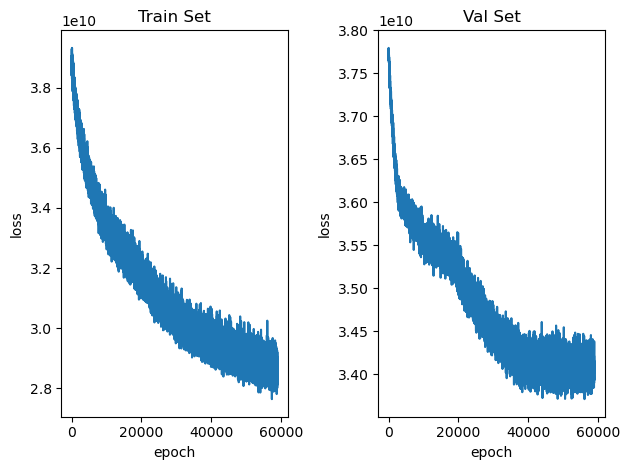

Best R Squared seen on epoch 57184: 0.8916
Best-R2-model with R2 above min_save_r2=0.88 and 0 invalid coefficients predicted on train/test sets:
	Validation R2: 0.8916
	Validation MAE: 131398.92
	Epoch seen: 57184
	Model file: C:\Users\nicklein\Documents\MEF-Regression\FF_models\hours_since_2018_feature\2023_04_02-12_17_58_PM\epoch=57184,r2=0.8916,Invalids=0.pth
Model Settings:
	n_input=5
	hidden_dims=[512, 256]
	n_out=3
	dropout_p=0.5
	bias_term=True
Optimizer Settings:
	learning_rate=0.005
	weight_decay=0.003
Loss Function Settings:
	loss_function=<function mse_loss_regularized_preds_l1 at 0x000001B9A0BBF160>
	MEF_reg_weight=1000000.0
	MDF_reg_weight=1000000.0
Train Process Settings:
	epochs=60000
	min_save_r2=0.88
Features: Load, VRE, Hour, Day_of_Year, Hours_since_2018


  0%|          | 0/60000 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=9.805e+11, R Squared=0.0004, Invalid MEFs=8058, Invalid MDFs=5752
	Val Set: Loss=5.476e+11, R Squared=-0.0002, Invalid MEFs=3353, Invalid MDFs=572
[Epoch 1000]
	Train Set: Loss=3.883e+10, R Squared=0.8731, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.755e+10, R Squared=0.8793, Invalid MEFs=0, Invalid MDFs=0
[Epoch 2000]
	Train Set: Loss=3.733e+10, R Squared=0.8780, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.684e+10, R Squared=0.8816, Invalid MEFs=0, Invalid MDFs=0
[Epoch 3000]
	Train Set: Loss=3.671e+10, R Squared=0.8801, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.634e+10, R Squared=0.8832, Invalid MEFs=0, Invalid MDFs=0
[Epoch 4000]
	Train Set: Loss=3.575e+10, R Squared=0.8835, Invalid MEFs=1, Invalid MDFs=0
	Val Set: Loss=3.602e+10, R Squared=0.8842, Invalid MEFs=0, Invalid MDFs=0
[Epoch 5000]
	Train Set: Loss=3.545e+10, R Squared=0.8851, Invalid MEFs=4, Invalid MDFs=0
	Val Set: Loss=3.589e+10, R Squared=0.8846, Invalid MEFs=0, Invalid MDFs=0
[

[Epoch 50000]
	Train Set: Loss=2.971e+10, R Squared=0.9032, Invalid MEFs=1, Invalid MDFs=0
	Val Set: Loss=3.413e+10, R Squared=0.8903, Invalid MEFs=0, Invalid MDFs=0
[Epoch 51000]
	Train Set: Loss=2.953e+10, R Squared=0.9038, Invalid MEFs=1, Invalid MDFs=0
	Val Set: Loss=3.432e+10, R Squared=0.8896, Invalid MEFs=0, Invalid MDFs=0
[Epoch 52000]
	Train Set: Loss=2.923e+10, R Squared=0.9047, Invalid MEFs=0, Invalid MDFs=1
	Val Set: Loss=3.436e+10, R Squared=0.8895, Invalid MEFs=0, Invalid MDFs=0
[Epoch 53000]
	Train Set: Loss=2.959e+10, R Squared=0.9037, Invalid MEFs=1, Invalid MDFs=1
	Val Set: Loss=3.398e+10, R Squared=0.8907, Invalid MEFs=0, Invalid MDFs=0
[Epoch 54000]
	Train Set: Loss=2.919e+10, R Squared=0.9053, Invalid MEFs=2, Invalid MDFs=1
	Val Set: Loss=3.440e+10, R Squared=0.8894, Invalid MEFs=0, Invalid MDFs=0
[Epoch 55000]
	Train Set: Loss=2.936e+10, R Squared=0.9048, Invalid MEFs=3, Invalid MDFs=0
	Val Set: Loss=3.425e+10, R Squared=0.8899, Invalid MEFs=0, Invalid MDFs=0
[Epo

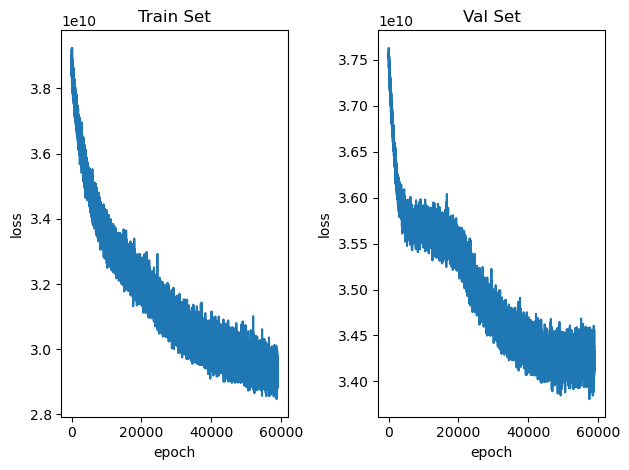

Best R Squared seen on epoch 58589: 0.8913
Best-R2-model with R2 above min_save_r2=0.88 and 0 invalid coefficients predicted on train/test sets:
	Validation R2: 0.8913
	Validation MAE: 132050.39
	Epoch seen: 58589
	Model file: C:\Users\nicklein\Documents\MEF-Regression\FF_models\hours_since_2018_feature\2023_04_02-12_35_47_PM\epoch=58589,r2=0.8913,Invalids=0.pth
Model Settings:
	n_input=5
	hidden_dims=[512, 256]
	n_out=3
	dropout_p=0.5
	bias_term=True
Optimizer Settings:
	learning_rate=0.01
	weight_decay=0.001
Loss Function Settings:
	loss_function=<function mse_loss_regularized_preds_l1 at 0x000001B9A0BBF160>
	MEF_reg_weight=1000000.0
	MDF_reg_weight=1000000.0
Train Process Settings:
	epochs=60000
	min_save_r2=0.88
Features: Load, VRE, Hour, Day_of_Year, Hours_since_2018


  0%|          | 0/60000 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=9.467e+11, R Squared=-0.0004, Invalid MEFs=5645, Invalid MDFs=11086
	Val Set: Loss=5.057e+11, R Squared=-0.0003, Invalid MEFs=1452, Invalid MDFs=4208
[Epoch 1000]
	Train Set: Loss=3.824e+10, R Squared=0.8751, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.740e+10, R Squared=0.8797, Invalid MEFs=0, Invalid MDFs=0
[Epoch 2000]
	Train Set: Loss=3.665e+10, R Squared=0.8806, Invalid MEFs=1, Invalid MDFs=0
	Val Set: Loss=3.659e+10, R Squared=0.8824, Invalid MEFs=0, Invalid MDFs=0
[Epoch 3000]
	Train Set: Loss=3.610e+10, R Squared=0.8820, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.610e+10, R Squared=0.8839, Invalid MEFs=0, Invalid MDFs=0
[Epoch 4000]
	Train Set: Loss=3.504e+10, R Squared=0.8863, Invalid MEFs=3, Invalid MDFs=0
	Val Set: Loss=3.599e+10, R Squared=0.8843, Invalid MEFs=0, Invalid MDFs=0
[Epoch 5000]
	Train Set: Loss=3.488e+10, R Squared=0.8876, Invalid MEFs=5, Invalid MDFs=1
	Val Set: Loss=3.563e+10, R Squared=0.8854, Invalid MEFs=0, Invalid MDFs=

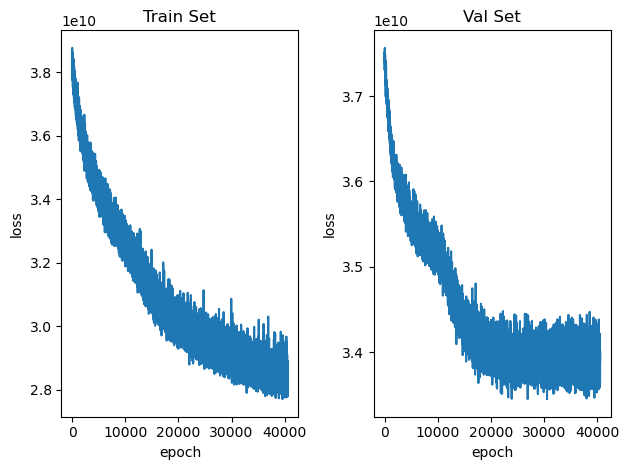

Best R Squared seen on epoch 31559: 0.8925
Best-R2-model with R2 above min_save_r2=0.88 and 0 invalid coefficients predicted on train/test sets:
	Validation R2: 0.8925
	Validation MAE: 130771.34
	Epoch seen: 31559
	Model file: C:\Users\nicklein\Documents\MEF-Regression\FF_models\hours_since_2018_feature\2023_04_02-12_58_55_PM\epoch=31559,r2=0.8925,Invalids=0.pth
Model Settings:
	n_input=5
	hidden_dims=[512, 256]
	n_out=3
	dropout_p=0.5
	bias_term=True
Optimizer Settings:
	learning_rate=0.01
	weight_decay=0.003
Loss Function Settings:
	loss_function=<function mse_loss_regularized_preds_l1 at 0x000001B9A0BBF160>
	MEF_reg_weight=1000000.0
	MDF_reg_weight=1000000.0
Train Process Settings:
	epochs=60000
	min_save_r2=0.88
Features: Load, VRE, Hour, Day_of_Year, Hours_since_2018


  0%|          | 0/60000 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=7.608e+11, R Squared=0.0007, Invalid MEFs=3646, Invalid MDFs=8945
	Val Set: Loss=4.296e+11, R Squared=-0.0001, Invalid MEFs=556, Invalid MDFs=3502
[Epoch 1000]
	Train Set: Loss=3.811e+10, R Squared=0.8755, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.726e+10, R Squared=0.8802, Invalid MEFs=0, Invalid MDFs=0
[Epoch 2000]
	Train Set: Loss=3.708e+10, R Squared=0.8791, Invalid MEFs=1, Invalid MDFs=0
	Val Set: Loss=3.644e+10, R Squared=0.8828, Invalid MEFs=0, Invalid MDFs=0
[Epoch 3000]
	Train Set: Loss=3.618e+10, R Squared=0.8821, Invalid MEFs=1, Invalid MDFs=0
	Val Set: Loss=3.606e+10, R Squared=0.8841, Invalid MEFs=0, Invalid MDFs=0
[Epoch 4000]
	Train Set: Loss=3.534e+10, R Squared=0.8850, Invalid MEFs=2, Invalid MDFs=0
	Val Set: Loss=3.585e+10, R Squared=0.8848, Invalid MEFs=0, Invalid MDFs=0
[Epoch 5000]
	Train Set: Loss=3.507e+10, R Squared=0.8864, Invalid MEFs=4, Invalid MDFs=0
	Val Set: Loss=3.564e+10, R Squared=0.8854, Invalid MEFs=0, Invalid MDFs=0
[

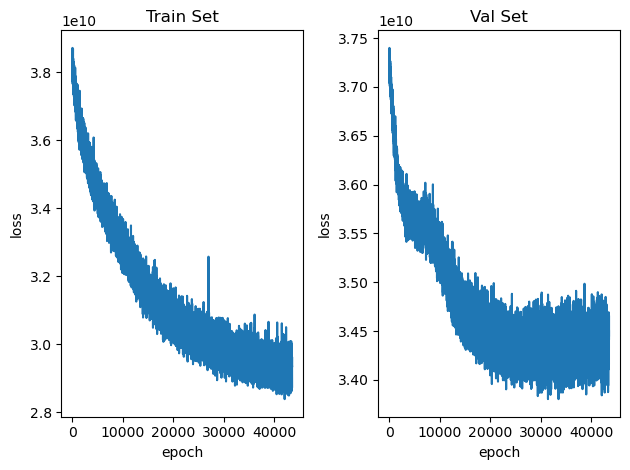

Best R Squared seen on epoch 34511: 0.8913
Best-R2-model with R2 above min_save_r2=0.88 and 0 invalid coefficients predicted on train/test sets:
	Validation R2: 0.8913
	Validation MAE: 131575.50
	Epoch seen: 34511
	Model file: C:\Users\nicklein\Documents\MEF-Regression\FF_models\hours_since_2018_feature\2023_04_02-01_16_34_PM\epoch=34511,r2=0.8913,Invalids=0.pth


In [28]:
hidden_dim_settings = [[512,256]]
lrs = [.005, .01]
weight_decays = [.001, .003]
dropout_probs = [0.5]
bias_term = True
regularization_weights = [[1e6,1e6]]
loss_function = mse_loss_regularized_preds_l1
save_prefix = "hours_since_2018_feature"

for hidden_dims in hidden_dim_settings:
    for lr in lrs:
        for weight_decay in weight_decays:
            for dropout_p in dropout_probs:
                for reg_weights in regularization_weights:
                    train_model_with_params(train_x, val_x, CAISO_train, CAISO_val, n_out, hidden_dims, lr, weight_decay, dropout_p,
                                            loss_function, *reg_weights, bias_term, save_prefix, epochs=60000, min_save_r2=.88)

## Inference on all data

In [29]:
## below we can load specific models instead of best one found in most recent experiment
# best_model_dir = os.path.join(model_save_dir, "base4_features\\2023_01_10-05_36_38_PM")
# best_model_file = os.path.join(best_model_dir, "epoch=37502,r2=0.8856,Invalids=0.pth")

# best_model_dir = os.path.join(model_save_dir, "base4_features\\2023_01_27-04_25_05_PM")
# best_model_file = os.path.join(best_model_dir, "epoch=30059,r2=0.8836,Invalids=0.pth")

# best_model_dir = os.path.join(model_save_dir, "hours_since_2018_feature\\2023_04_01-04_51_40_PM")
# best_model_file = os.path.join(best_model_dir, "epoch=29757,r2=0.8918,Invalids=0.pth")

best_model_dir = os.path.join(model_save_dir, "hours_since_2018_feature\\2023_04_01-05_23_36_PM")
best_model_file = os.path.join(best_model_dir, "epoch=35779,r2=0.8933,Invalids=0.pth")

In [30]:
best_model_file

'C:\\Users\\nicklein\\Documents\\MEF-Regression\\FF_models\\hours_since_2018_feature\\2023_04_01-05_23_36_PM\\epoch=35779,r2=0.8933,Invalids=0.pth'

In [31]:
hidden_dims = [512,256]
bias_term = True
dropout_p = 0.5
n_input = train_x.shape[1]

model = get_model(n_input, hidden_dims, n_out, dropout_p)
model.to(device)
model.load_state_dict(torch.load(best_model_file))
model.eval()

train_pred_coeff = model(train_x.float()).cpu()
val_pred_coeff = model(val_x.float()).cpu()
test_pred_coeff = model(test_x.float()).cpu()

results_str = "R Squared:"
results_str += f"\n\tTrain: {get_r_squared(train_pred_coeff, CAISO_train, bias_term):.4f}"
results_str += f"\n\tVal: {get_r_squared(val_pred_coeff, CAISO_val, bias_term):.4f}"
results_str += f"\n\tTest: {get_r_squared(test_pred_coeff, CAISO_test, bias_term):.4f}"
results_str += "\nMean Absolute Error:"
results_str += f"\n\tTrain: {get_mean_abs_err(train_pred_coeff, CAISO_train, bias_term):.2f}"
results_str += f"\n\tVal: {get_mean_abs_err(val_pred_coeff, CAISO_val, bias_term):.2f}"
results_str += f"\n\tTest: {get_mean_abs_err(test_pred_coeff, CAISO_test, bias_term):.2f}"
results_str += "\nCount Invalid Values Predicted:"
invalid_train_MEFs, invalid_train_MDFs = get_count_invalid_preds(train_pred_coeff)
invalid_val_MEFs, invalid_val_MDFs = get_count_invalid_preds(val_pred_coeff)
invalid_test_MEFs, invalid_test_MDFs = get_count_invalid_preds(test_pred_coeff)
results_str += f"\n\tTrain: Invalid MEFs={invalid_train_MEFs}, Invalid MDFs={invalid_train_MDFs}"
results_str += f"\n\tVal: Invalid MEFs={invalid_val_MEFs}, Invalid MDFs={invalid_val_MDFs}"
results_str += f"\n\tTest: Invalid MEFs={invalid_test_MEFs}, Invalid MDFs={invalid_test_MDFs}"

with open(os.path.join(best_model_dir, "eval_results.txt"), 'w+') as f:
    f.write(results_str)
print(results_str)

R Squared:
	Train: 0.9164
	Val: 0.8933
	Test: 0.8929
Mean Absolute Error:
	Train: 116886.63
	Val: 130745.96
	Test: 126760.97
Count Invalid Values Predicted:
	Train: Invalid MEFs=0, Invalid MDFs=0
	Val: Invalid MEFs=0, Invalid MDFs=0
	Test: Invalid MEFs=0, Invalid MDFs=0


### Put the MEFs and MDFs from all sets back together and in order into the original DF for viewing

In [32]:
all_preds_w_timestamps = list(zip(CAISO_val.index, val_pred_coeff.detach().numpy())) \
                        + list(zip(CAISO_train.index, train_pred_coeff.detach().numpy())) \
                        + list(zip(CAISO_test.index, test_pred_coeff.detach().numpy()))
all_preds_w_timestamps.sort(key=lambda pair: pair[0])
all_preds_ordered = np.array([pair[1] for pair in all_preds_w_timestamps])

In [33]:
all_MEFs_ordered = all_preds_ordered[:,0]
all_MDFs_ordered = all_preds_ordered[:,1]
all_intercepts_ordered = all_preds_ordered[:,2]

In [34]:
CAISO_Data.loc[:,"MEF"] = all_MEFs_ordered
CAISO_Data.loc[:,"MDF"] = all_MDFs_ordered
if bias_term:
    CAISO_Data.loc[:,"Intercept"] = all_intercepts_ordered

#calculate some error stuff. rn i am thinking R2 is the best measure of error
d_emissions = CAISO_Data.loc[:,'MEF'] * CAISO_Data.loc[:,'delta_Load'] \
            + CAISO_Data.loc[:,'MDF'] * CAISO_Data.loc[:,'delta_VRE']
if bias_term:
    d_emissions += CAISO_Data.loc[:,"Intercept"]
CAISO_Data.loc[:,'Predicted_delta_Total_CO2_Emissions'] = d_emissions
CAISO_Data.loc[:,'Error']=CAISO_Data.loc[:,'Predicted_delta_Total_CO2_Emissions']-CAISO_Data.loc[:,'delta_Total_CO2_Emissions']
CAISO_Data.loc[:,'%_Error']=np.abs(CAISO_Data.loc[:,'Error'])/np.abs(CAISO_Data.loc[:,'delta_Total_CO2_Emissions'])
print("Whole Data Set:")
print(f"\tMean Emissions Change = {np.mean(np.abs(CAISO_Data['delta_Total_CO2_Emissions'])):.2f}")
print(f"\tR Squared = {r2_score(CAISO_Data['delta_Total_CO2_Emissions'], CAISO_Data['Predicted_delta_Total_CO2_Emissions']):.4f}")
print(f"\tMean Absolute Error = {mean_absolute_error(CAISO_Data['delta_Total_CO2_Emissions'], CAISO_Data['Predicted_delta_Total_CO2_Emissions']):.2f}")

Whole Data Set:
	Mean Emissions Change = 413162.83
	R Squared = 0.9071
	Mean Absolute Error = 121633.36


In [35]:
CAISO_Data.head()

,Load,Net Load,Total_CO2_Emissions,Total_SO2_Emissions,Total_NOX_Emissions,VRE,delta_Load,delta_Net_Load,delta_Total_CO2_Emissions,delta_Total_SO2_Emissions,...,delta_VRE,Day_of_Year,Hour,Hours_since_2018,MEF,MDF,Intercept,Predicted_delta_Total_CO2_Emissions,Error,%_Error
2019-01-01 00:00:00,22822.964472,20502.358502,5.103942e+06,425.327933,1632.821698,2320.593616,-1285.054865,-1255.110267,-337029.794143,-24.142180,...,-29.956338,1,0,0.0,353.528137,-371.433807,-6224.517090,-449400.772935,-112370.978792,0.333416
2019-01-01 01:00:00,21879.620618,19606.836908,4.867578e+06,404.315852,1557.650531,2272.780097,-944.689268,-896.922625,-243021.833700,-21.594332,...,-47.757034,1,1,1.0,343.447388,-378.015320,-3581.676025,-309979.846821,-66958.013122,0.275523
2019-01-01 02:00:00,21257.454020,19056.267637,4.723101e+06,383.695714,1496.197481,2201.182455,-614.641020,-545.206677,-144846.797503,-20.952957,...,-69.432802,1,2,2.0,335.775330,-347.679260,-1740.398315,-183981.344085,-39134.546581,0.270179
2019-01-01 03:00:00,20974.800758,18871.418601,4.693112e+06,380.561848,1466.329836,2103.388502,-281.391674,-191.565227,-24776.569759,-2.164379,...,-89.815150,1,3,3.0,327.608185,-323.038849,-1105.669189,-64278.102160,-39501.532401,1.594310
2019-01-01 04:00:00,20327.083333,18012.666667,5.032423e+06,711.911968,2391.657870,2314.666667,30.416667,74.416667,49254.136541,69.703951,...,-43.916667,1,4,4.0,319.256622,-290.810150,-634.734131,21847.400558,-27406.735982,0.556435


In [36]:
CAISO_Data.to_csv(os.path.join(best_model_dir, "CAISO_Data_2019_2021_NN.with_coeff_preds.csv"))

In [37]:
len([val for val in CAISO_Data.loc[:,"MEF"] if val <=0])

0

In [38]:
len([val for val in CAISO_Data.loc[:,"MEF"] if val >600])

0

In [39]:
CAISO_Data.loc[:,"MEF"].max()

580.9650268554688

In [40]:
len([val for val in CAISO_Data.loc[:,"MDF"] if val < -600])

40

In [41]:
CAISO_Data.loc[:,"MDF"].min()

-803.3059692382812